In [1]:
!pip install pygame
!pip install gym==0.26.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827652 sha256=e3b1740c1441e4501d16590d1de0d865bb9b58889a1a1e26297122a9084f21b8
  Stored in directory: /root/.cache/pip/wheels/af/2b/30/5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordEpisodeStatistics
gymlogger.set_level(40) #error only
from torch import nn
import torch
from torch.nn import functional as F
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from base64 import b64encode

from IPython import display as ipythondisplay
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
def show_video(episode):
  mp4 = open(f'/content/videos/0.25.2/rl-video-episode-{episode}.mp4','rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  ipythondisplay.display(HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url))

In [3]:
gym.__version__

'0.26.2'

In [4]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode = "rgb_array")

# env = gym.wrappers.RecordEpisodeStatistics(env)
# env = gym.wrappers.RecordVideo(env, f"videos/{gym.__version__}")

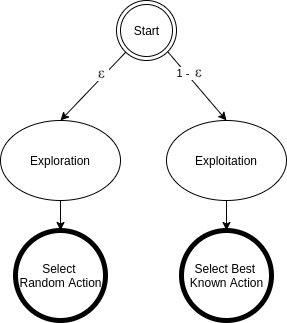

参考:https://www.baeldung.com/cs/epsilon-greedy-q-learning

In [5]:
class QLearningTable:
  def __init__(self, actions, terminal, learning_rate=0.01, reward_decay=0.9, e_greedy=0.1):
    self.actions = actions
    self.lr = learning_rate
    self.gamma = reward_decay
    self.epsilon = e_greedy
    self.q_table = pd.DataFrame(columns = self.actions, dtype=np.float64)
    self.terminal = terminal

  def choose_action(self, observation, is_test):
    self.check_state_exist(observation)


    if np.random.uniform()>self.epsilon or is_test==True:
      state_action = self.q_table.loc[observation, :]
      action = np.random.choice(state_action[state_action == np.max(state_action)].index)
    else:
      action = np.random.choice(self.actions)
    return action

  def learn(self, s, a, r, s_):
    self.check_state_exist(s_)
    q_predict = self.q_table.loc[s, a]
    if s_ != self.terminal:
      q_target = r+self.gamma*self.q_table.loc[s_, :].max()
    else:
      q_target = r
    self.q_table.loc[s, a] += self.lr*(q_target-q_predict)
    # print(self.q_table.loc[s, a])



  def check_state_exist(self, state):
    # print(self.q_table)
    if state not in self.q_table.index:
      self.q_table.loc[state] = [0]*len(self.actions)

In [6]:
RL = QLearningTable(range(4), 15, learning_rate=0.5, e_greedy=0.8)

In [7]:
success = 0
total_episode = 500
for episode in range(total_episode):
  observation, info = env.reset()
  while True:
    env.render()
    action = RL.choose_action(observation, False)
    observation_, rewards, terminated, truncated, infos = env.step(action)
    if terminated and observation_ != 15:
      rewards = -1
    else:
      rewards *= 2
    RL.learn(observation, action, rewards, observation_)
    observation = observation_
    # print(RL.q_table)
    if terminated:
      if observation == 15:
        # print("success")
        # print(RL.q_table)
        success += 1
      break
print(success/total_episode)

0.096


In [8]:
RL.q_table

,0,1,2,3
0,1.062882,1.180980,1.180980,1.062882
4,1.180980,1.312200,-1.000000,1.062882
1,1.062882,-1.000000,1.312200,1.180979
8,1.312200,-1.000000,1.458000,1.180980
12,0.000000,0.000000,0.000000,0.000000
2,1.180979,1.458000,1.180890,1.312199
5,0.000000,0.000000,0.000000,0.000000
6,-0.996094,1.620000,-1.000000,1.294897
10,1.457995,1.800000,-0.999999,1.456564
7,0.000000,0.000000,0.000000,0.000000


In [10]:
#test
test_success = 0
test_total_episode = 1000
for episode in range(test_total_episode):
  observation, info = env.reset()
  while True:
    env.render()
    action = RL.choose_action(observation, True)
    observation_, rewards, terminated, truncated, infos = env.step(action)
    observation = observation_
    if terminated:
      if observation == 15:
        test_success += 1
      break
print(test_success/test_total_episode)

1.0


In [11]:
RL.q_table

,0,1,2,3
0,1.062882,1.180980,1.180980,1.062882
4,1.180980,1.312200,-1.000000,1.062882
1,1.062882,-1.000000,1.312200,1.180979
8,1.312200,-1.000000,1.458000,1.180980
12,0.000000,0.000000,0.000000,0.000000
2,1.180979,1.458000,1.180890,1.312199
5,0.000000,0.000000,0.000000,0.000000
6,-0.996094,1.620000,-1.000000,1.294897
10,1.457995,1.800000,-0.999999,1.456564
7,0.000000,0.000000,0.000000,0.000000
